# DEM Processing

In [1]:
from __future__ import annotations

import shutil
from pathlib import Path
from tempfile import TemporaryDirectory
from typing import TYPE_CHECKING

import geopandas as gpd
import pywbt
import rioxarray as rxr

import seamless_3dep as sdem

if TYPE_CHECKING:
    import xarray as xr

Let's start by getting a HUC8 geometry from [GeoConnex](https://docs.geoconnex.us/) web service for St. Vrain region in Colorado. Note that we need to make sure that geometry is in 4326 projection.

In [2]:
url = "https://reference.geoconnex.us/collections/hu08/items/10190005"
vrain = gpd.read_file(url)
geom_org = vrain.to_crs(4326).union_all()
geom = vrain.to_crs(5070).buffer(5e3).to_crs(4326).union_all()

We can use `get_dem` to get the DEM but this function only returns DEM in 4326 projection. Since we want to analyze the DEM using WhiteboxTools and it's better to have the input DEM be in a projected CRS, instead, we use `get_map` to get the DEM in 5070 projection. Note that since we're getting the DEM in 5070 projection, it's a good idea to add some padding to the bounding box to make sure the obtained maps will not end up having NaN values within our original bounding box. In this case, we add a 5-km buffer to the bounding box.

In [3]:
data_dir = Path("data")
tiff_files = sdem.get_map("DEM", geom.bounds, data_dir, 10, out_crs=5070)

We then use `build_vrt` to build a VRT file from the obtained GeoTIFF files so we can then use `rioxarray` to read the data into an `xarray.DataArray`.

In [4]:
def read_file(tiff_files: list[Path]) -> xr.DataArray:
    """Convert a list of tiff files to a vrt file and return a xarray.DataArray."""
    first = tiff_files[0]
    if len(tiff_files) == 1:
        file = first
    else:
        file = first.with_suffix(".vrt")
        sdem.build_vrt(file, tiff_files)
    return rxr.open_rasterio(file).squeeze(drop=True).rio.clip_box(*geom_org.bounds, crs=4326)


dem = read_file(tiff_files)
dem.size

33524424

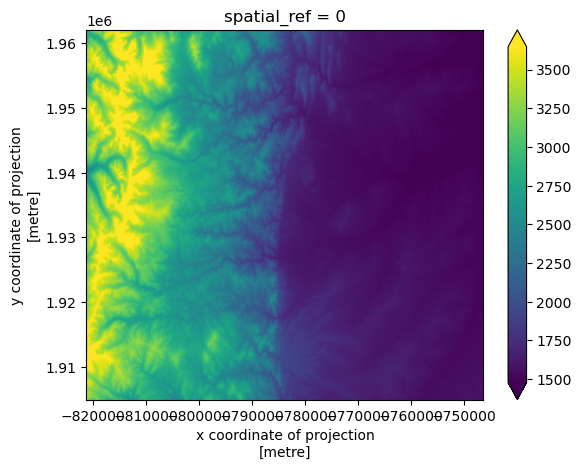

In [5]:
ax = dem.plot.imshow(robust=True)
ax.figure.savefig("images/dem.png")

Now, we use [PyWBT](https://pywbt.readthedocs.io/latest/) package to compute Topographic Wetness Index (TWI).

In [6]:
twi_files = [data_dir / fname.name.replace("dem", "twi") for fname in tiff_files]
slope_files = [data_dir / fname.name.replace("dem", "slope") for fname in tiff_files]
for dname, tname, sname in zip(tiff_files, twi_files, slope_files, strict=False):
    with TemporaryDirectory(dir=data_dir) as temp:
        shutil.copy(dname, temp)
        wbt_args = {
            "BreachDepressions": [f"-i={dname.name}", "--fill_pits", "-o=dem_corr.tiff"],
            "D8Pointer": ["-i=dem_corr.tiff", "-o=fdir.tiff"],
            "D8FlowAccumulation": [
                "-i=fdir.tiff",
                "--pntr",
                "--out_type='specific contributing area'",
                "-o=sca.tiff",
            ],
            "Slope": ["-i=dem_corr.tiff", "--units=degrees", f"-o={sname.name}"],
            "WetnessIndex": ["--sca=sca.tiff", f"--slope={sname.name}", f"-o={tname.name}"],
        }
        pywbt.whitebox_tools(temp, wbt_args, [sname.name, tname.name], temp)
        shutil.copy(Path(temp) / tname.name, data_dir)
        shutil.copy(Path(temp) / sname.name, data_dir)

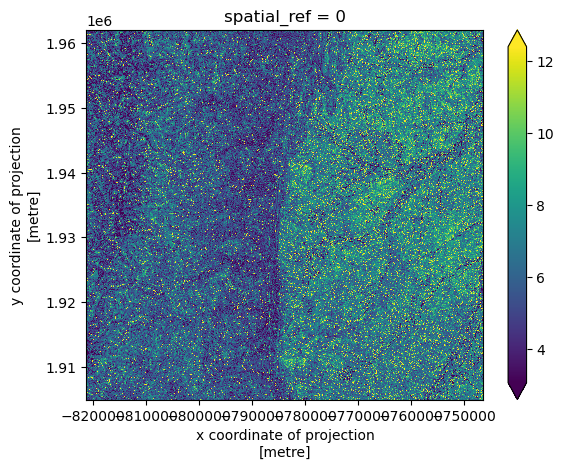

In [7]:
twi = read_file(twi_files)
ax = twi.plot.imshow(robust=True)
ax.figure.savefig("images/twi.png")

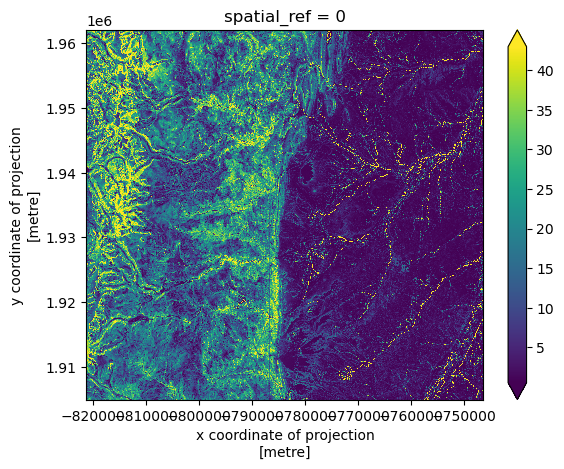

In [8]:
slope = read_file(slope_files)
ax = slope.plot.imshow(robust=True)
ax.figure.savefig("images/slope.png")

We can directly get slope using `get_map` function and passing `map_type="Slope Degrees"`

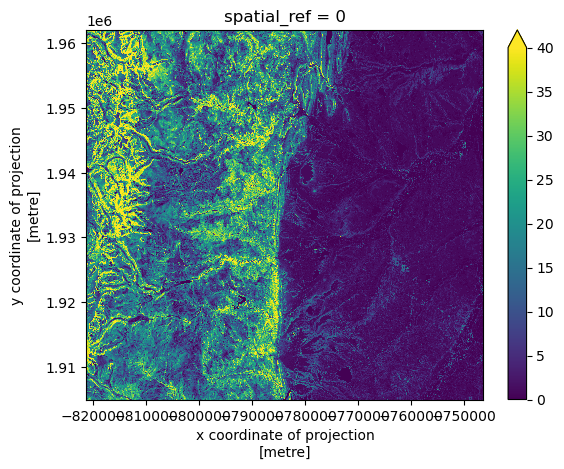

In [9]:
tiff_files = sdem.get_map("Slope Degrees", geom.bounds, data_dir, 10)
slope = read_file(tiff_files)
ax = slope.plot.imshow(robust=True)
ax.figure.savefig("images/slope_dynamic.png")